Code for the analysis of the MADE architecture

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Custom colormaps
sunset = [
    "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"
]

ptog = [
    "#40004b", "#762a83", "#9970ab", "#c2a5cf", "#e7d4e8",
    "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837", "#00441b"
]

# Definitions of general functions

Definition of the standard Metropolis Monte Carlo

In [4]:
def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

def montecarlo_CW(N, beta, pop_size, num_sweeps):
    # Population of spins, randomly initialized to -1 or 1
    pop = 2.*torch.randint(0, 2, (pop_size, N), device="cuda") - 1.

    
    # Loop to update the population using the Monte Carlo method
    for i in range(0, num_sweeps):  # Maximum number of iterations
        for n in range(N):
            # Perform a Monte Carlo update for the entire population
            pop = monte_carlo_update_CW(pop, N, beta)
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return pop

Definition of the MADE

In [5]:
class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

# Plots of the weights

In [6]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

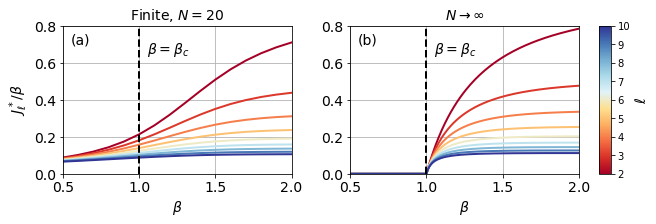

In [16]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", sunset)

N = 20 #Size of the system

# Load data
df_finite = pd.read_csv(f"../Data/Jl_N{N}_diffbeta.txt", delim_whitespace=True)
df_infinite = pd.read_csv("../Data/Jl_Ninf_diffbeta.txt", delim_whitespace=True)

# ℓ values
unique_ells = sorted(df_finite["ℓ"].unique())
norm = mcolors.Normalize(vmin=min(unique_ells), vmax=max(unique_ells))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)

# Create figure with GridSpec and constrained layout
fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.000001, 1, 0.05])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
cax = fig.add_subplot(gs[3])  # Colorbar axis

# Plot for finite N
for ell in unique_ells:
    group = df_finite[df_finite["ℓ"] == ell]
    color = custom_cmap(norm(ell))
    ax1.plot(group["β"], group["J_ℓ/β"], color=color, lw=2)

ax1.set_title("Finite, $N=20$", fontsize = 14)
ax1.set_xlabel(r"$\beta$", fontsize = 14)
ax1.set_ylabel(r"$J^*_\ell / \beta$", fontsize = 14)
ax1.axvline(x=1, color='black', linestyle='--', lw=2)
ax1.text(1.05, 0.65, r'$\beta = \beta_c$', fontsize=14)
ax1.text(0.55, 0.70, r'(a)', fontsize=14)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlim(0.5, 2)
ax1.set_ylim(0, 0.8)

# Plot for N → ∞
for ell in unique_ells:
    group = df_infinite[df_infinite["ℓ"] == ell]
    if not group.empty:
        color = custom_cmap(norm(ell))
        ax2.plot(group["β"], group["J_ℓ/β"], color=color, lw=2)

ax2.set_title(r"$N \rightarrow \infty$", fontsize = 14)
ax2.set_xlabel(r"$\beta$", fontsize = 14)
ax2.axvline(x=1, color='black', linestyle='--', lw=2)
ax2.text(0.55, 0.70, r'(b)', fontsize=14)
ax2.text(1.05, 0.65, r'$\beta = \beta_c$', fontsize=14)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlim(0.5, 2)
ax2.set_ylim(0, 0.8)

# Colorbar
cbar = fig.colorbar(sm, cax=cax, ticks=unique_ells)
cbar.set_label(r"$\ell$", fontsize = 14)

plt.savefig("../Plots/Jl_N20_diffbeta.pdf")

plt.show()


# Plot of the gradient

In [45]:
def gradients_computer(N, dataset, optimal, epsilon=0.1, num_points=20):
    """
    Computes gradients of the loss with respect to structured weight perturbations
    in a lower-triangular matrix model. For each row i, it perturbs the shared value
    used in the allowed (i.e., j <= i) positions, computes the model's loss gradient
    with respect to that value, and returns a dictionary of (offset, gradient) pairs.

    Args:
        dataset (torch.Tensor): Input data.
        optimal (torch.Tensor): Optimal shared values per row in the weight matrix.
        epsilon (float): Fractional range for candidate offsets.
        num_points (int): Number of offset values to evaluate per row.

    Returns:
        dict: {row_index: [(offset, gradient), ...]} for each row.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = made(N)  # assume your MADE model definition is available
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0)  # dummy optimizer
    criterion = nn.BCELoss(reduction="sum")

    gradients = {}
    num_rows, num_cols = N, N  # assumes square weight matrix

    for i in range(num_rows):
        gradients[i] = []
        allowed_mask = torch.arange(num_cols, device=device) < i
        optimal_J_i = optimal[i]

        offsets = torch.linspace(-epsilon +0* optimal_J_i, epsilon +0* optimal_J_i, steps=num_points, device=device)

        for offset in offsets:
            candidate_value = optimal_J_i + offset

            # Create new weight matrix and set tied values
            new_weight = torch.zeros_like(model.layer.weight)
            new_weight[i, allowed_mask] = candidate_value
            new_weight = new_weight.clone().detach().requires_grad_(True)

            # Override model weights
            model.layer.weight = nn.Parameter(new_weight)

            # Compute gradient of loss
            optimizer.zero_grad()
            output = model(dataset)
            loss = criterion(output, (dataset + 1) / 2) / len(dataset)
            loss.backward()

            # Accumulate gradient from tied entries
            grad_i = model.layer.weight.grad[i, allowed_mask].sum().item() if i != 0 else 0
            gradients[i].append((offset.item(), grad_i))

    return gradients

We simulate a population of configurations to compute the averages

In [35]:
#parameters of the simulation
N = 20
beta = 1
pop_size = 5000000
num_sweeps = 30

#load the exact couplings
W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

Then, we compute the gradients and compare the ones obtained from data with the ones found by linearizing

In [48]:
gradients = gradients_computer(N, pop, W, epsilon = 0.04, num_points=40)

Angular coefficient for key 1: 0.9555778184428751
Angular coefficient for key 7: 11.692630529304902
Angular coefficient for key 11: 24.08169056485672
Angular coefficient for key 14: 36.192174797914504
Angular coefficient for key 19: 61.80100848839608


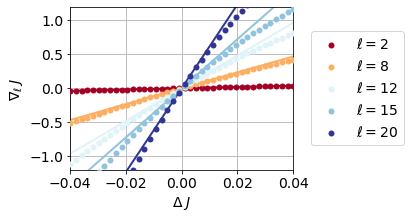

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fontsize = 14

plt.figure(figsize=(4, 3))

# Set colormap to 'suset' and normalization range
cmap = mcolors.LinearSegmentedColormap.from_list("custom", sunset)
norm = plt.Normalize(vmin=1, vmax=19)

# Load Hessian data
hessian = np.loadtxt(f"../Data/hessian_N{N}_beta{beta}.txt")

# Plot for selected keys
for key in [1, 7, 11,14, 19]:
    gradient_values = gradients[key]
    candidate_values = np.array([item[0] for item in gradient_values])
    gradient_magnitudes = np.array([item[1] for item in gradient_values])
    
    # Compute and display the angular coefficient via linear fit
    coeffs = np.polyfit(candidate_values, gradient_magnitudes, 1)
    print(f'Angular coefficient for key {key}: {coeffs[0]}')
    
    # Pre-calculate x-values for the line
    x_vals = np.linspace(-0.04, 0.04, 10)
    plt.plot(x_vals, x_vals * hessian[key-1, 1] ,
             color=cmap(norm(key)), lw = 2)
    plt.scatter(candidate_values, gradient_magnitudes,
                color=cmap(norm(key)), edgecolor='black', linewidth=0.1, label=rf"$\ell = {key+1}$", zorder = 3)

plt.xlabel(r'$\Delta \; J$', fontsize=fontsize)
plt.ylabel(r'$\nabla_\ell \; J$', fontsize=fontsize)
plt.xlim(-0.04, 0.04)
plt.ylim(-1.2, 1.2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.grid(True)
plt.savefig("../Plots/gradients_N20.pdf")
plt.show()
